## Ground-Up CENSUS FOOD DESERT ANALYSIS

#### This module is to ignore potential unwanted warnings

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [137]:
import pandas as pd # manipulation of datasets  
import geopandas as gpd # manipulation of datasets with shapes/geometry
import matplotlib.pyplot as plt # visualization of the datasets
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import os
import numpy as np
import requests 
import folium
from shapely.geometry import Point, box
import time

#### Importing Network Analysis Modules

In [5]:
import osmnx as ox
import networkx as nx
from joblib import Parallel, delayed

### Reading Indiana Census Tract File 2019

#### This file can be found at https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html#list-tab-790442341

In [ ]:
Indiana = gpd.read_file("Indiana_TIGER/tl_2019_18_tract.shp")

In [ ]:
Indiana

### Download Poverty, Income, Population, Vehicle Access Datasets from data.census.gov

#### Follow these instructions in order to download the correct dataset:

In [ ]:
# poverty 2014-2018 ACS 
poverty = pd.read_csv("ACSST5Y2018.S1701-Data.csv",skiprows=[1,1])

In [ ]:
# income 2014-2018 ACS
income = pd.read_csv("ACSST5Y2018.S1901-Data.csv",skiprows=[1,1])

In [ ]:
# population 2019, derived from 2010 census
population = pd.read_csv("ACSDP5Y2019.DP05-Data.csv",skiprows=[1,1])

In [ ]:
# vehicle access 2014-2018 ACS
vehicle = pd.read_csv("ACSST5Y2018.S2504-Data.csv",skiprows=[1,1])

In [ ]:
poverty['GEO_ID'] = poverty['GEO_ID'].str.split('S').str[1]
income['GEO_ID'] = income['GEO_ID'].str.split('S').str[1]
population['GEO_ID'] = population['GEO_ID'].str.split('S').str[1]
vehicle['GEO_ID'] = vehicle['GEO_ID'].str.split('S').str[1]

### Merge the Datasets with Census Tract for the State

In [ ]:
# Convert both columns to string to ensure proper merging
Indiana["GEOID"] = Indiana["GEOID"].astype(str)
poverty["GEO_ID"] = poverty["GEO_ID"].astype(str)
income["GEO_ID"] = income["GEO_ID"].astype(str)
population["GEO_ID"] = population["GEO_ID"].astype(str)
vehicle["GEO_ID"] = vehicle["GEO_ID"].astype(str)

In [ ]:
# Select specific columns from each DataFrame
# Adding GEO_ID for merging
# Rename columns from each DataFrame
poverty_subset = poverty.iloc[:, [0, 2, 124, 126]].rename(columns={
    poverty.columns[2]: 'totalpop',
    poverty.columns[124]: 'belowpoverty',
    poverty.columns[126]: 'percentpoverty',
    poverty.columns[0]: 'GEO_ID'
})

income_subset = income.iloc[:, [0, 2, 24, 26, 34, 100, 106]].rename(columns={
    income.columns[2]: 'tothouseholds',
    income.columns[24]: 'medhouse',
    income.columns[26]: 'meanhouse',
    income.columns[34]: 'totfam',
    income.columns[100]: 'medfam',
    income.columns[106]: 'meanfam',
    income.columns[0]: 'GEO_ID'
})

population_subset = population.iloc[:, [0, 2, 172]].rename(columns={
    population.columns[2]: 'pop2010',
    population.columns[172]: 'houseunits',
    population.columns[0]: 'GEO_ID'
})

vehicle_subset = vehicle.iloc[:, [0, 2, 54, 78]].rename(columns={
    vehicle.columns[2]: 'occhousingunits',
    vehicle.columns[54]: 'novehicles',
    vehicle.columns[78]: 'percenthouseunits',
    vehicle.columns[0]: 'GEO_ID'
})

In [ ]:
# Merge all DataFrames, dropping GEO_ID after each merge
Indiana_FoodDesert = (Indiana
                     .merge(poverty_subset, left_on="GEOID", right_on="GEO_ID", how="inner")
                     .drop(columns="GEO_ID")  # Drop GEO_ID after every merge
                     .merge(income_subset, left_on="GEOID", right_on="GEO_ID", how="inner")
                     .drop(columns="GEO_ID")  
                     .merge(population_subset, left_on="GEOID", right_on="GEO_ID", how="inner")
                     .drop(columns="GEO_ID") 
                     .merge(vehicle_subset, left_on="GEOID", right_on="GEO_ID", how="inner")
                     .drop(columns="GEO_ID"))  

# If there are still duplicates, remove them
Indiana_FoodDesert = Indiana_FoodDesert.loc[:, ~Indiana_FoodDesert.columns.duplicated()]

In [ ]:
Indiana_FoodDesert

### Fix/Clean the Data

In [ ]:
# replace X with NaN if needed
Indiana_FoodDesert = Indiana_FoodDesert.replace('(X)', np.nan)

In [ ]:
Indiana_FoodDesert.columns.tolist()

### Save the Indiana Food Desert File

In [ ]:
Indiana_FoodDesert.to_file("Indiana_FoodDesert.shp")

### Dividing by Grid Cells

In [ ]:
# Step 1: Define US bounds in lat/lon (WGS84, EPSG:4326)
us_bounds = {
    'minx': -125.0,  # Western edge (Washington)
    'miny': 24.396308,  # Southern edge (Florida)
    'maxx': -66.93457,  # Eastern edge (Maine)
    'maxy': 49.384358  # Northern edge (Washington/Minnesota)
}

# Create a bounding box for the US in lat/lon
us_bbox = gpd.GeoDataFrame(
    geometry=[box(us_bounds['minx'], us_bounds['miny'], us_bounds['maxx'], us_bounds['maxy'])],
    crs="EPSG:4326"
)

# Project to Albers Equal Area (EPSG:5070) for accurate grid cell size
us_bbox = us_bbox.to_crs(epsg=5070)
minx, miny, maxx, maxy = us_bbox.total_bounds

In [ ]:
# Define grid cell size (0.5 km = 500 meters)
cell_size = 500

# Create a grid covering the US
x_coords = np.arange(minx, maxx + cell_size, cell_size)
y_coords = np.arange(miny, maxy + cell_size, cell_size)
grid_cells = [box(x, y, x + cell_size, y + cell_size) for x in x_coords[:-1] for y in y_coords[:-1]]
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=us_bbox.crs)

# Step 2: Load Indiana census tracts and project to the same CRS
indiana_tracts = Indiana_FoodDesert.copy()
indiana_tracts = indiana_tracts.to_crs(epsg=5070)

In [ ]:
# Clip the US grid to Indiana's boundaries
indiana_bounds = indiana_tracts.dissolve().geometry[0]  # Combine all Indiana tracts into one geometry
grid_indiana = gpd.sjoin(grid, indiana_tracts[['geometry']], how='inner', predicate='intersects')
grid_indiana = grid_indiana.drop(columns=['index_right'])

In [ ]:
# Step 3: Intersect grid with Indiana tracts and calculate intersection areas
grid_indiana = gpd.overlay(grid_indiana, indiana_tracts, how='intersection')
grid_indiana['area'] = grid_indiana.geometry.area  # Area of each intersection in square meters

In [ ]:
# Step 4: Assign population based on tract population (using 'pop2010')
# Calculate tract area and population density
indiana_tracts['tract_area'] = indiana_tracts.geometry.area
indiana_tracts['pop_density'] = indiana_tracts['pop2010'].astype(float) / indiana_tracts['tract_area']

In [ ]:
# Merge population density into grid_indiana
grid_indiana = grid_indiana.merge(indiana_tracts[['GEOID', 'pop_density']], on='GEOID', how='left')

In [ ]:
# Calculate population for each grid cell portion
grid_indiana['grid_population'] = grid_indiana['area'] * grid_indiana['pop_density']

In [ ]:
# Step 5: Handle grid cells spanning multiple tracts by summing population contributions
grid_indiana['grid_id'] = grid_indiana.index  # Temporary unique ID
grid_population = grid_indiana.groupby('grid_id')['grid_population'].sum().reset_index()

In [ ]:
grid_indiana

In [ ]:
# Merge summed population back with unique grid geometries
grid_final = grid_indiana[['grid_id', 'geometry']].drop_duplicates().merge(grid_population, on='grid_id')

In [ ]:
# Clean up the final GeoDataFrame
grid_final = gpd.GeoDataFrame(grid_final[['geometry', 'grid_population']], crs=grid_indiana.crs)

In [ ]:
grid_final

In [ ]:
# save the grided file

In [ ]:
grid_indiana.to_file("grided_Indiana.shp")

## Checkpoint

### Read the Grided Indiana File

In [9]:
grid_indiana = gpd.read_file("grided_Indiana.shp")

In [11]:
grid_indiana

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,pop2010,houseunits,occhousing,novehicles,percenthou,area,pop_densit,grid_popul,grid_id,geometry
0,18,129,040500,18129040500,405,Census Tract 405,G5020,S,332882879,17312686,...,3578,1574,1417,50,1417,25601.713313,0.000010,0.261576,0,"POLYGON ((687629.385 1680310.629, 687629.385 1..."
1,18,129,040500,18129040500,405,Census Tract 405,G5020,S,332882879,17312686,...,3578,1574,1417,50,1417,78583.740322,0.000010,0.802902,1,"POLYGON ((687629.385 1680810.629, 687629.385 1..."
2,18,129,040500,18129040500,405,Census Tract 405,G5020,S,332882879,17312686,...,3578,1574,1417,50,1417,2936.348343,0.000010,0.030001,2,"POLYGON ((687629.385 1680810.629, 687560.683 1..."
3,18,129,040500,18129040500,405,Census Tract 405,G5020,S,332882879,17312686,...,3578,1574,1417,50,1417,9559.596863,0.000010,0.097672,3,"POLYGON ((688129.385 1679310.629, 688129.385 1..."
4,18,129,040500,18129040500,405,Census Tract 405,G5020,S,332882879,17312686,...,3578,1574,1417,50,1417,166400.674496,0.000010,1.700140,4,"POLYGON ((688129.385 1679810.629, 688129.385 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534190,18,155,965700,18155965700,9657,Census Tract 9657,G5020,S,216447434,5466574,...,4786,2301,1757,25,1757,247344.653056,0.000022,5.334461,534190,"POLYGON ((961629.385 1817810.629, 961129.385 1..."
534191,18,155,965700,18155965700,9657,Census Tract 9657,G5020,S,216447434,5466574,...,4786,2301,1757,25,1757,126882.956306,0.000022,2.736474,534191,"POLYGON ((961129.385 1818310.629, 961129.385 1..."
534192,18,155,965700,18155965700,9657,Census Tract 9657,G5020,S,216447434,5466574,...,4786,2301,1757,25,1757,21578.379515,0.000022,0.465379,534192,"POLYGON ((961629.385 1817310.629, 961699.352 1..."
534193,18,155,965700,18155965700,9657,Census Tract 9657,G5020,S,216447434,5466574,...,4786,2301,1757,25,1757,40818.249435,0.000022,0.880324,534193,"POLYGON ((961629.385 1817310.629, 961629.385 1..."


In [ ]:
grid_indiana.plot()

### Centroid Calculation

In [13]:
# Step 1: Calculate centroids for each grid cell in grid_indiana
grid_indiana['centroid'] = grid_indiana.geometry.centroid

In [15]:
grid_indiana

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,houseunits,occhousing,novehicles,percenthou,area,pop_densit,grid_popul,grid_id,geometry,centroid
0,18,129,040500,18129040500,405,Census Tract 405,G5020,S,332882879,17312686,...,1574,1417,50,1417,25601.713313,0.000010,0.261576,0,"POLYGON ((687629.385 1680310.629, 687629.385 1...",POINT (687582.634 1680188.936)
1,18,129,040500,18129040500,405,Census Tract 405,G5020,S,332882879,17312686,...,1574,1417,50,1417,78583.740322,0.000010,0.802902,1,"POLYGON ((687629.385 1680810.629, 687629.385 1...",POINT (687548.263 1680546.989)
2,18,129,040500,18129040500,405,Census Tract 405,G5020,S,332882879,17312686,...,1574,1417,50,1417,2936.348343,0.000010,0.030001,2,"POLYGON ((687629.385 1680810.629, 687560.683 1...",POINT (687605.764 1680838.355)
3,18,129,040500,18129040500,405,Census Tract 405,G5020,S,332882879,17312686,...,1574,1417,50,1417,9559.596863,0.000010,0.097672,3,"POLYGON ((688129.385 1679310.629, 688129.385 1...",POINT (688078.438 1679268.928)
4,18,129,040500,18129040500,405,Census Tract 405,G5020,S,332882879,17312686,...,1574,1417,50,1417,166400.674496,0.000010,1.700140,4,"POLYGON ((688129.385 1679810.629, 688129.385 1...",POINT (687953.194 1679595.042)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534190,18,155,965700,18155965700,9657,Census Tract 9657,G5020,S,216447434,5466574,...,2301,1757,25,1757,247344.653056,0.000022,5.334461,534190,"POLYGON ((961629.385 1817810.629, 961129.385 1...",POINT (961376.834 1818058.456)
534191,18,155,965700,18155965700,9657,Census Tract 9657,G5020,S,216447434,5466574,...,2301,1757,25,1757,126882.956306,0.000022,2.736474,534191,"POLYGON ((961129.385 1818310.629, 961129.385 1...",POINT (961299.601 1818477.059)
534192,18,155,965700,18155965700,9657,Census Tract 9657,G5020,S,216447434,5466574,...,2301,1757,25,1757,21578.379515,0.000022,0.465379,534192,"POLYGON ((961629.385 1817310.629, 961699.352 1...",POINT (961656.427 1817130.938)
534193,18,155,965700,18155965700,9657,Census Tract 9657,G5020,S,216447434,5466574,...,2301,1757,25,1757,40818.249435,0.000022,0.880324,534193,"POLYGON ((961629.385 1817310.629, 961629.385 1...",POINT (961670.345 1817567.683)


In [ ]:
#Indiana_FoodDesert['Centroid'] = Indiana_FoodDesert.geometry.centroid

In [ ]:
#Indiana_FoodDesert['Centroid_LatLon'] = Indiana_FoodDesert['Centroid'].apply(
 #   lambda point: (point.y, point.x)  # (latitude, longitude)
#)

## Get Grocery Locations through Open Street Map Geocoding

In [17]:
def get_locations(categories, queries, cities, state, country, brand=None):
    """Fetch locations from OpenStreetMap using Overpass API."""
    overpass_url = "http://overpass-api.de/api/interpreter"
    all_locations = []

    # Construct the optional brand filter
    brand_filter = f'["brand"="{brand}"]' if brand else ''

    # Handle multiple categories, queries, and cities
    if not categories or not queries or not cities:
        print("No categories, queries, or cities provided.")
        return []

    for category in categories:
        for city in cities:
            for query in queries:
                overpass_query = f"""
                [out:json];
                area[name="{city}"]->.searchArea;
                (
                  node["{category}"="{query}"]{brand_filter}(area.searchArea);
                  way["{category}"="{query}"]{brand_filter}(area.searchArea);
                  relation["{category}"="{query}"]{brand_filter}(area.searchArea);
                );
                out center;
                """
                
                try:
                    response = requests.get(overpass_url, params={'data': overpass_query})
                    response.raise_for_status()
                    data = response.json()
                    all_locations.extend(data.get("elements", []))
                except requests.exceptions.RequestException as e:
                    print(f"Request error for {category}={query} in {city}: {e}")
                except requests.exceptions.JSONDecodeError:
                    print(f"Error decoding JSON response from API for {category}={query} in {city}.")

    return all_locations

In [19]:
def plot_locations(data, city, state, country):
    """Plot locations on a Folium map."""
    if not data:
        print("No locations found.")
        return None

    # Extract the first valid location for map centering
    for place in data:
        lat = place.get('lat') or (place.get('center', {}).get('lat'))
        lon = place.get('lon') or (place.get('center', {}).get('lon'))
        if lat and lon:
            m = folium.Map(location=[lat, lon], zoom_start=12)
            break
    else:
        print("No valid coordinates found.")
        return None

    # Add markers
    for place in data:
        lat = place.get('lat') or (place.get('center', {}).get('lat'))
        lon = place.get('lon') or (place.get('center', {}).get('lon'))
        if lat and lon:
            name = place.get('tags', {}).get('name', 'Unknown')
            folium.Marker([lat, lon], popup=f"{name} ({lat}, {lon})").add_to(m)

    return m

In [21]:
def display_locations(data):
    """Display location names with coordinates in a DataFrame."""
    locations = []
    for place in data:
        lat = place.get('lat') or (place.get('center', {}).get('lat'))
        lon = place.get('lon') or (place.get('center', {}).get('lon'))
        if lat and lon:
            name = place.get('tags', {}).get('name', 'Unknown')
            locations.append([name, lat, lon])
    
    df = pd.DataFrame(locations, columns=['Name', 'Latitude', 'Longitude'])
    return df

In [23]:
# Example Query Parameters
category = ["shop"]  # General category
queries = ["supermarket", "department_store", "greengrocer", "farm", "health_food", "retail"]  # Multiple specific queries
#cities = ["Indianapolis", "Lawrence"]  # Cities in Marion County, IN
cities = ["Indiana"]
state = "Indiana"
country = "USA"
brand = None  # Change to "Walmart" or "Target" if needed or None 

# Fetch Data
data = get_locations(category, queries, cities, state, country, brand)

# Plot Data on Map
map_result = plot_locations(data, cities[0] if cities else None, state, country)

# Display DataFrame of Locations
df_locations = display_locations(data)

# Display the map and data
if map_result:
    display(map_result)

display(df_locations)

,Name,Latitude,Longitude
0,Martin's Super Markets,41.626897,-86.237049
1,Martin's Super Markets,41.660269,-86.214137
2,Martin's Super Markets,41.700778,-86.218231
3,Kroger,41.076615,-85.276150
4,Kroger,39.955048,-85.996069
...,...,...,...
962,The Wellness Shoppe,41.518439,-87.335641
963,Vibrations,41.601779,-87.268376
964,Lakefront Nutrition and Fitness,41.679157,-87.493465
965,The Olive Branch,41.225557,-85.822398


#### Convert fetched locations (df_locations) to a GeoDataFrame with Point geometries to perform distance calculation

In [25]:
supermarkets = gpd.GeoDataFrame(
    df_locations,
    geometry=[Point(lon, lat) for lon, lat in zip(df_locations['Longitude'], df_locations['Latitude'])],
    crs="EPSG:4326")

In [27]:
supermarkets

,Name,Latitude,Longitude,geometry
0,Martin's Super Markets,41.626897,-86.237049,POINT (-86.23705 41.6269)
1,Martin's Super Markets,41.660269,-86.214137,POINT (-86.21414 41.66027)
2,Martin's Super Markets,41.700778,-86.218231,POINT (-86.21823 41.70078)
3,Kroger,41.076615,-85.276150,POINT (-85.27615 41.07661)
4,Kroger,39.955048,-85.996069,POINT (-85.99607 39.95505)
...,...,...,...,...
962,The Wellness Shoppe,41.518439,-87.335641,POINT (-87.33564 41.51844)
963,Vibrations,41.601779,-87.268376,POINT (-87.26838 41.60178)
964,Lakefront Nutrition and Fitness,41.679157,-87.493465,POINT (-87.49346 41.67916)
965,The Olive Branch,41.225557,-85.822398,POINT (-85.8224 41.22556)


In [29]:
supermarkets = supermarkets.to_crs(epsg=5070)  # Project to Albers Equal Area

In [31]:
supermarkets_gdf = supermarkets

## To reduce the scope of the search we will instead choose to perform the analysis for a smaller area. 
#### Marion county has a countyFP of 097. https://unicede.air-worldwide.com/unicede/unicede_indiana_fips_3.html
#### This helps reduce the computation times significantly.

In [ ]:
#Marion = Indiana_FoodDesert[Indiana_FoodDesert['COUNTYFP'] == '097']

In [ ]:
#Marion

### We create the Road Network using Network Analysis Module with Python

In [ ]:
#G = ox.graph_from_place("Marion County, Indiana, USA", network_type="drive") # uncomment after downloading the road-network for the area

In [ ]:
#ox.save_graphml(G, filepath="Marion_road_network.graphml") # save it such that you do not need to download it again

In [33]:
G = ox.load_graphml("indiana_road_network.graphml")

In [34]:
G = ox.project_graph(G, to_crs="EPSG:5070")

In [ ]:
ox.plot_graph(G)

#### Calculate the Nearest Supermarket from Grid

In [37]:
# Step 4: Find nearest OSM nodes for grid centroids and supermarkets using vectorized approach
start_time = time.time()

# Extract x, y coordinates as NumPy arrays
grid_x = grid_indiana['centroid'].apply(lambda point: point.x).to_numpy()
grid_y = grid_indiana['centroid'].apply(lambda point: point.y).to_numpy()
market_x = supermarkets_gdf.geometry.x.to_numpy()
market_y = supermarkets_gdf.geometry.y.to_numpy()

# Use OSMnx vectorized nearest_nodes function
grid_indiana['nearest_node'] = ox.distance.nearest_nodes(G, grid_x, grid_y)
supermarkets_gdf['nearest_node'] = ox.distance.nearest_nodes(G, market_x, market_y)

end_time = time.time()
print(f"Nearest Nodes Execution Time: {end_time - start_time:.2f} seconds")

Nearest Nodes Execution Time: 35.49 seconds


In [39]:
# Convert to sets to avoid duplicates
grid_nodes = set(grid_indiana['nearest_node'].dropna())
market_nodes = set(supermarkets_gdf['nearest_node'].dropna())

In [41]:
# Step 5: Compute shortest paths from all supermarket nodes to all grid nodes in one go
start_time = time.time()

# Use multi-source Dijkstra to find the shortest path from the closest supermarket to each node
path_lengths = nx.multi_source_dijkstra_path_length(G, sources=market_nodes, weight='length')

# Extract distances for grid nodes only, convert to km
grid_to_market_distances = {
    grid_node: path_lengths.get(grid_node, float('inf')) / 1000  # Convert to km
    for grid_node in grid_nodes
}

# Map distances back to the DataFrame
grid_indiana['distance'] = grid_indiana['nearest_node'].map(grid_to_market_distances)

end_time = time.time()
print(f"Network Distance Execution Time: {end_time - start_time:.2f} seconds")

Network Distance Execution Time: 6.46 seconds


In [43]:
grid_indiana['distance'] = grid_indiana['distance'] * 0.621371 # convert to miles

In [45]:
grid_indiana['distance'].median()

6.789099719593166

In [47]:
# Clean up: drop temporary columns if desired
grid_indiana = grid_indiana.drop(columns=['centroid', 'nearest_node'])

In [49]:
grid_indiana.to_file("grided_Indiana.shp")

# Checkpoint

In [8]:
Indiana = gpd.read_file("grided_Indiana.shp")

In [23]:
Indiana.columns.tolist()

['STATEFP',
 'COUNTYFP',
 'TRACTCE',
 'GEOID',
 'NAME',
 'NAMELSAD',
 'MTFCC',
 'FUNCSTAT',
 'ALAND',
 'AWATER',
 'INTPTLAT',
 'INTPTLON',
 'Field',
 'totalpop',
 'belowpover',
 'percentpov',
 'tothouseho',
 'medhouse',
 'meanhouse',
 'totfam',
 'medfam',
 'meanfam',
 'pop2010',
 'houseunits',
 'occhousing',
 'novehicles',
 'percenthou',
 'area',
 'pop_densit',
 'grid_popul',
 'grid_id',
 'distance',
 'Metro',
 'NAME_1',
 'geometry']

In [7]:
Indiana

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,novehicles,percenthou,area,pop_densit,grid_popul,grid_id,distance,Metro,NAME_1,geometry
0,18,129,040500,18129040500,405,Census Tract 405,G5020,S,332882879,17312686,...,50,1417,25601.713313,0.000010,0.261576,0,12.331584,Yes,"Evansville, IN-KY","POLYGON ((687629.385 1680310.629, 687629.385 1..."
1,18,129,040500,18129040500,405,Census Tract 405,G5020,S,332882879,17312686,...,50,1417,78583.740322,0.000010,0.802902,1,12.331584,Yes,"Evansville, IN-KY","POLYGON ((687629.385 1680810.629, 687629.385 1..."
2,18,129,040500,18129040500,405,Census Tract 405,G5020,S,332882879,17312686,...,50,1417,2936.348343,0.000010,0.030001,2,12.331584,Yes,"Evansville, IN-KY","POLYGON ((687629.385 1680810.629, 687560.683 1..."
3,18,129,040500,18129040500,405,Census Tract 405,G5020,S,332882879,17312686,...,50,1417,9559.596863,0.000010,0.097672,3,12.331584,Yes,"Evansville, IN-KY","POLYGON ((688129.385 1679310.629, 688129.385 1..."
4,18,129,040500,18129040500,405,Census Tract 405,G5020,S,332882879,17312686,...,50,1417,166400.674496,0.000010,1.700140,4,12.331584,Yes,"Evansville, IN-KY","POLYGON ((688129.385 1679810.629, 688129.385 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534190,18,155,965700,18155965700,9657,Census Tract 9657,G5020,S,216447434,5466574,...,25,1757,247344.653056,0.000022,5.334461,534190,6.200459,Yes,"Cincinnati, OH-KY-IN","POLYGON ((961629.385 1817810.629, 961129.385 1..."
534191,18,155,965700,18155965700,9657,Census Tract 9657,G5020,S,216447434,5466574,...,25,1757,126882.956306,0.000022,2.736474,534191,6.200459,Yes,"Cincinnati, OH-KY-IN","POLYGON ((961129.385 1818310.629, 961129.385 1..."
534192,18,155,965700,18155965700,9657,Census Tract 9657,G5020,S,216447434,5466574,...,25,1757,21578.379515,0.000022,0.465379,534192,6.200459,Yes,"Cincinnati, OH-KY-IN","POLYGON ((961629.385 1817310.629, 961699.352 1..."
534193,18,155,965700,18155965700,9657,Census Tract 9657,G5020,S,216447434,5466574,...,25,1757,40818.249435,0.000022,0.880324,534193,6.200459,Yes,"Cincinnati, OH-KY-IN","POLYGON ((961629.385 1817310.629, 961629.385 1..."


In [11]:
Indiana['GEOID'].describe()

count          534195
unique           1511
top       18123952200
freq             2851
Name: GEOID, dtype: object

## Choose a Random Tract to Visualize it

In [13]:
#Marion = Indiana[Indiana['NAMELSAD'] == 'Census Tract 405']
Marion = Indiana[Indiana['NAMELSAD'] == 'Census Tract 3101.03']

In [35]:
Marion['grid_households'].describe()

count    251.000000
mean      10.203187
std        4.453283
min        0.076827
25%        7.492498
50%       13.360340
75%       13.464002
max       13.464002
Name: grid_households, dtype: float64

<Axes: >

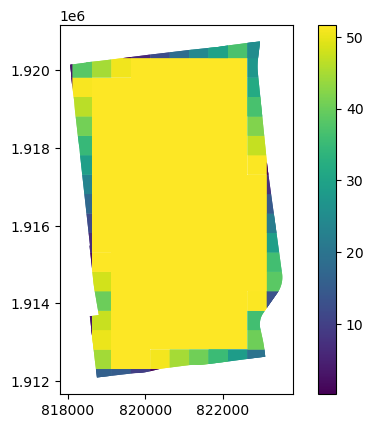

In [97]:
Marion.plot(column='grid_popul', legend=True, cmap='viridis')

<Axes: >

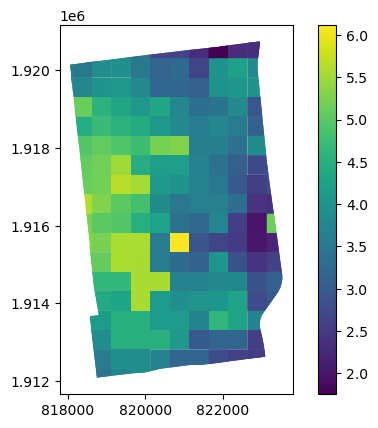

In [15]:
Marion.plot(column='distance', legend=True, cmap='viridis') # distance

### Read the Pre-Requisite Files

#### - Metro Income File
#### - Default USDA Food Desert File (for Comparison)

In [19]:
# Load the metro income data
Metro = pd.read_csv("Metro_Indiana_Income.csv")

In [117]:
#Load the USDA default data
default = gpd.read_file("Indiana_TIGER/Indiana_Tract_Food.shp")

##### Convert to Numeric Data Type for Appropriate Calculations

In [23]:
Indiana["medfam"] = pd.to_numeric(Indiana["medfam"], errors="coerce")
Indiana["percentpov"] = pd.to_numeric(Indiana["percentpov"], errors="coerce")

## PLOTTING!

In [25]:
# Drop low_income_status if it already exists to avoid merge conflicts
if 'low_income_status' in Indiana.columns:
    Indiana = Indiana.drop(columns=['low_income_status'])

In [27]:
# Step 1: Compute low-income status at tract level
medfam_threshold = 0.8 * Indiana["medfam"].median()

def get_metro_threshold(row, metro_df):
    if row["Metro"] == "Yes":
        metro_row = metro_df[metro_df["Name"] == row["NAME_1"]]
        if not metro_row.empty:
            return 0.8 * metro_row["Median_Income"].iloc[0]
    return None

def is_low_income(row, metro_df):
    metro_threshold = get_metro_threshold(row, metro_df)
    if row["percentpov"] >= 20 or row["medfam"] <= medfam_threshold or (metro_threshold is not None and row["medfam"] <= metro_threshold):
        return "Yes"
    return "No"

Indiana['GEOID'] = Indiana['GEOID'].astype(str)
tract_low_income = Indiana.groupby('GEOID').first().reset_index()
tract_low_income['GEOID'] = tract_low_income['GEOID'].astype(str)
tract_low_income['low_income_status'] = tract_low_income.apply(lambda row: is_low_income(row, Metro), axis=1)

Indiana = Indiana.merge(tract_low_income[['GEOID', 'low_income_status']], on='GEOID', how='left')

In [29]:
# Step 2: Estimate households per grid
tract_area_totals = Indiana.groupby('GEOID')['area'].sum().reset_index()
tract_area_totals.rename(columns={'area': 'total_area'}, inplace=True)
Indiana = Indiana.merge(tract_area_totals, on='GEOID', how='left')
Indiana['area_proportion'] = Indiana['area'] / Indiana['total_area']
Indiana['grid_households'] = Indiana['tothouseho'] * Indiana['area_proportion']
Indiana['grid_novehicles'] = Indiana.apply(
    lambda row: (row['novehicles'] / row['tothouseho'] * row['grid_households']) if row['tothouseho'] > 0 and row['novehicles'] > 0 else 0,
    axis=1
)

In [31]:
# Step 3: Create a dictionary of unique GEOIDs
tract_dict = {}
for geoid in Indiana['GEOID'].unique():
    tract_dict[geoid] = Indiana[Indiana['GEOID'] == geoid][[
        'low_income_status', 'grid_popul', 'distance', 'totalpop', 'geometry',
        'grid_households', 'grid_novehicles'
    ]]

In [33]:
# Step 4: Define urban/rural classification and distance thresholds
def is_rural(row):
    return row['totalpop'] < 2500

urban_distance_threshold = 1.0  # miles
rural_distance_threshold = 10.0  # miles
no_vehicle_distance_threshold = 0.5  # miles
far_distance_threshold = 20.0  # miles

In [35]:
# Step 5: Process tracts to evaluate low-income and low-access
all_tracts = []
for geoid, tract_data in tract_dict.items():
    tract_totalpop = tract_data['totalpop'].iloc[0]
    low_income_status = tract_data['low_income_status'].iloc[0]
    tract_geometry = tract_data['geometry'].unary_union
    
    # Low-income check
    is_low_income = low_income_status == "Yes"
    
    # Low-access check for low-income tracts
    is_low_access_low_income = False
    if is_low_income:
        is_tract_rural = is_rural(tract_data.iloc[0])
        distance_threshold = rural_distance_threshold if is_tract_rural else urban_distance_threshold
        far_grids = tract_data[tract_data['distance'] > distance_threshold]
        far_population = far_grids['grid_popul'].sum()
        if tract_totalpop > 0:
            far_percentage = (far_population / tract_totalpop) * 100
        else:
            far_percentage = 0
        if far_population >= 500 or far_percentage >= 33:
            is_low_access_low_income = True
    
    # Low-access check for non-low-income tracts (USDA criteria)
    is_low_access_non_low_income = False
    if not is_low_income:
        # Option 1: Households > 0.5 miles with no vehicle access
        far_no_vehicle_grids = tract_data[
            (tract_data['distance'] > no_vehicle_distance_threshold) &
            (tract_data['grid_novehicles'] > 0)
        ]
        far_no_vehicle_households = far_no_vehicle_grids['grid_novehicles'].sum()
        # Option 2: Population > 20 miles (no vehicle check)
        far_grids = tract_data[tract_data['distance'] > far_distance_threshold]
        far_population = far_grids['grid_popul'].sum()
        if tract_totalpop > 0:
            far_percentage = (far_population / tract_totalpop) * 100
        else:
            far_percentage = 0
        if far_no_vehicle_households >= 100 or far_population >= 500 or far_percentage >= 33:
            is_low_access_non_low_income = True
    
    # Low-access overall (either income-based or USDA criteria)
    is_low_access = is_low_access_low_income or is_low_access_non_low_income
    
    all_tracts.append({
        'GEOID': geoid,
        'low_income_status': low_income_status,
        'is_low_access': is_low_access,
        'is_low_access_low_income': is_low_access_low_income,
        'is_low_access_non_low_income': is_low_access_non_low_income,
        'geometry': tract_geometry
    })

all_tracts_gdf = gpd.GeoDataFrame(all_tracts, geometry='geometry')

In [37]:
# Step 6: Reproject to Mercator (EPSG:3857)
all_tracts_gdf = all_tracts_gdf.set_crs(epsg=5070, allow_override=True)
all_tracts_gdf = all_tracts_gdf.to_crs(epsg=3857)

Indiana_boundary = Indiana.dissolve().boundary
Indiana_boundary = Indiana_boundary.set_crs(epsg=5070, allow_override=True)
Indiana_boundary = Indiana_boundary.to_crs(epsg=3857)

### This will take a Few Minutes

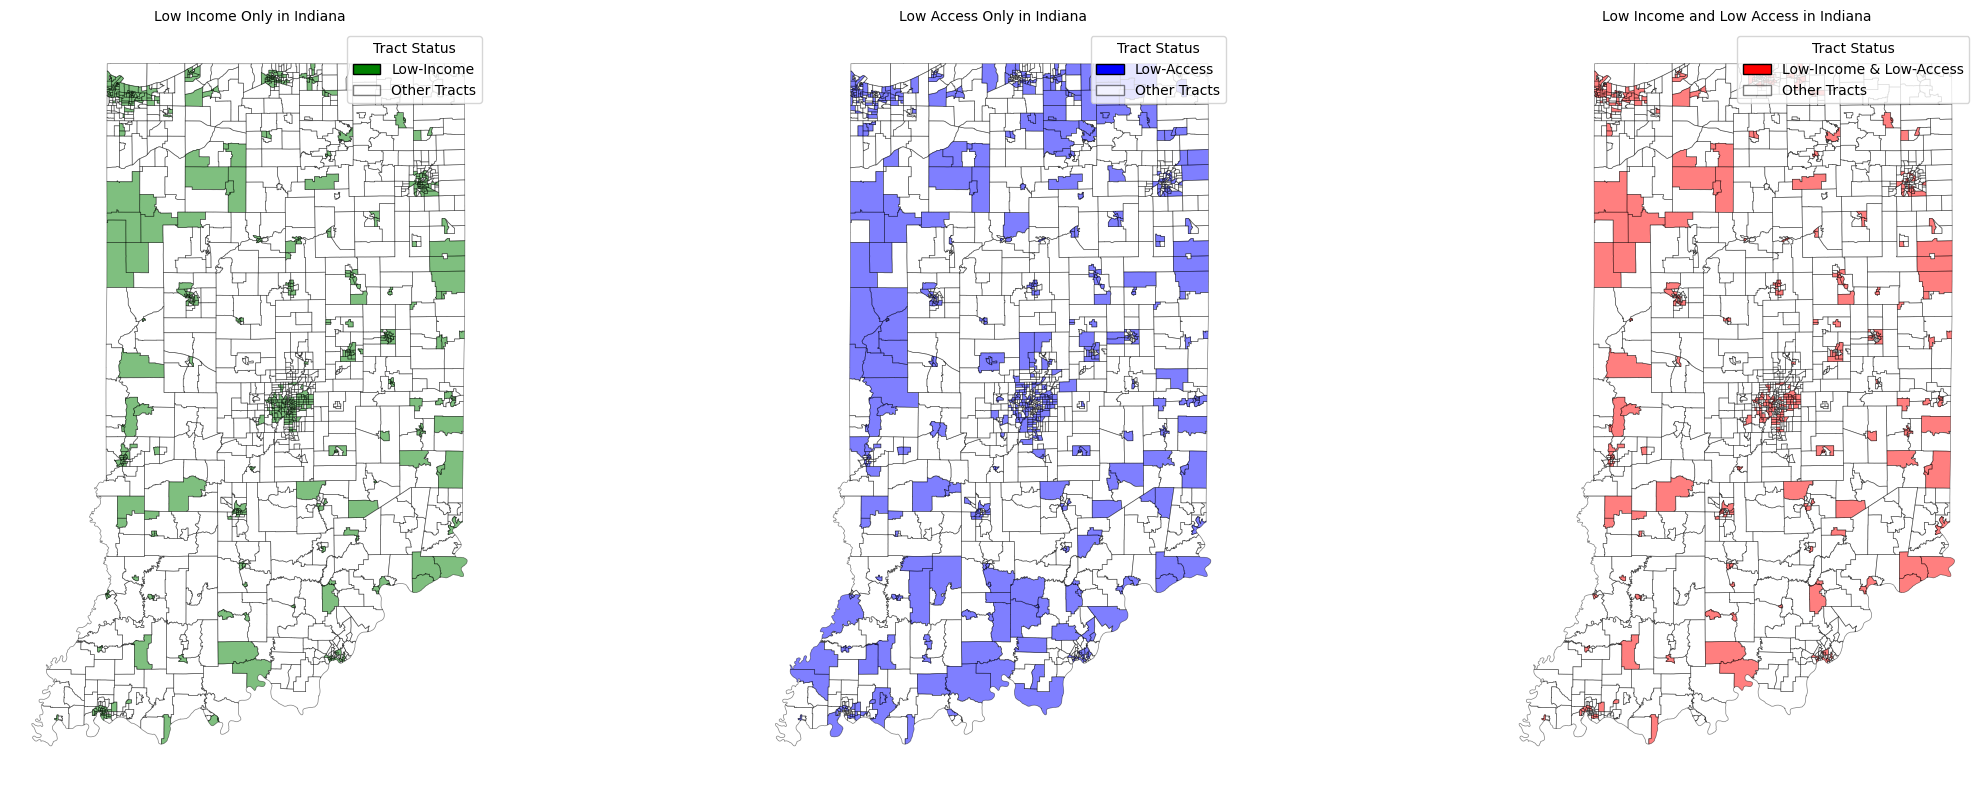

In [44]:
# Step 7: Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

# Plot 1: Low Income Only
Indiana_boundary.plot(ax=ax1, color='none', edgecolor='gray', linewidth=1.0, alpha=0.7, zorder=1)
colors1 = ['green' if row['low_income_status'] == "Yes" else 'white' for _, row in all_tracts_gdf.iterrows()]
all_tracts_gdf.plot(color=colors1, edgecolor='black', linewidth=0.5, ax=ax1, alpha=0.5, zorder=2)
ax1.set_title('Low Income Only in Indiana', fontsize=10)
legend_elements1 = [
    Patch(facecolor='green', edgecolor='black', label='Low-Income'),
    Patch(facecolor='white', edgecolor='black', label='Other Tracts', alpha=0.5)
]
ax1.legend(handles=legend_elements1, loc='upper right', title='Tract Status')
ax1.set_axis_off()

# Plot 2: Low Access Only
Indiana_boundary.plot(ax=ax2, color='none', edgecolor='gray', linewidth=1.0, alpha=0.7, zorder=1)
colors2 = ['blue' if row['is_low_access'] else 'white' for _, row in all_tracts_gdf.iterrows()]
all_tracts_gdf.plot(color=colors2, edgecolor='black', linewidth=0.5, ax=ax2, alpha=0.5, zorder=2)
ax2.set_title('Low Access Only in Indiana', fontsize=10)
legend_elements2 = [
    Patch(facecolor='blue', edgecolor='black', label='Low-Access'),
    Patch(facecolor='white', edgecolor='black', label='Other Tracts', alpha=0.5)
]
ax2.legend(handles=legend_elements2, loc='upper right', title='Tract Status')
ax2.set_axis_off()

# Plot 3: Low Income and Low Access
Indiana_boundary.plot(ax=ax3, color='none', edgecolor='gray', linewidth=1.0, alpha=0.7, zorder=1)
colors3 = ['red' if row['low_income_status'] == "Yes" and row['is_low_access'] else 'white' for _, row in all_tracts_gdf.iterrows()]
all_tracts_gdf.plot(color=colors3, edgecolor='black', linewidth=0.5, ax=ax3, alpha=0.5, zorder=2)
ax3.set_title('Low Income and Low Access in Indiana', fontsize=10)
legend_elements3 = [
    Patch(facecolor='red', edgecolor='black', label='Low-Income & Low-Access'),
    Patch(facecolor='white', edgecolor='black', label='Other Tracts', alpha=0.5)
]
ax3.legend(handles=legend_elements3, loc='upper right', title='Tract Status')
ax3.set_axis_off()

# Adjust layout to prevent overlap
plt.tight_layout()

### Comparison Accuracy with Default Data 

#### This will be the file that we get after running the Basic Food Desert Tutorial

In [46]:
# Step 1: Extract classifications from all_tracts_gdf
# Low Income Only: 1 if low_income_status == "Yes", 0 otherwise
# Low Access Only: 1 if is_low_access == True, 0 otherwise
# Low Income and Low Access: 1 if low_income_status == "Yes" and is_low_access == True, 0 otherwise
calculated_values = all_tracts_gdf[['GEOID']].copy()
calculated_values['low_income'] = all_tracts_gdf['low_income_status'].apply(lambda x: 1 if x == "Yes" else 0)
calculated_values['low_access'] = all_tracts_gdf['is_low_access'].apply(lambda x: 1 if x else 0)
calculated_values['low_income_and_low_access'] = all_tracts_gdf.apply(
    lambda row: 1 if row['low_income_status'] == "Yes" and row['is_low_access'] else 0,
    axis=1
)
# Ensure GEOID is string type for consistent merging
default['GEOID'] = default['GEOID'].astype(str)
calculated_values['GEOID'] = calculated_values['GEOID'].astype(str)

In [48]:
# Step 2: Merge with default data
merged = default[['GEOID', 'LowIncomeT', 'LA1and10', 'LILATracts']].merge(
    calculated_values,
    on='GEOID',
    how='left'
)

# Diagnostic: Check for unmatched GEOIDs
print("Number of unmatched GEOIDs:", merged['low_income'].isna().sum())
if merged['low_income'].isna().sum() > 0:
    print("Unmatched GEOIDs:", set(merged['GEOID']) - set(calculated_values['GEOID']))

Number of unmatched GEOIDs: 0


In [50]:
# Step 3: Calculate differences
# Low Income Only: Compare with LowIncomeT
merged['diff_low_income'] = merged['LowIncomeT'] - merged['low_income']
# Low Access Only: Compare with LA1and10
merged['diff_low_access'] = merged['LA1and10'] - merged['low_access']
# Low Income and Low Access: Compare with LILATracts
merged['diff_low_income_low_access'] = merged['LILATracts'] - merged['low_income_and_low_access']

In [57]:
merged

,GEOID,LowIncomeT,LA1and10,LILATracts,low_income,low_access,low_income_and_low_access,diff_low_income,diff_low_access,diff_low_income_low_access
0,18001030100,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
1,18001030200,1.0,1.0,1.0,1,1,1,0.0,0.0,0.0
2,18001030300,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
3,18001030400,0.0,1.0,0.0,0,0,0,0.0,1.0,0.0
4,18001030500,1.0,0.0,0.0,1,1,1,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...
1506,18183050300,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
1507,18183050400,0.0,1.0,0.0,0,0,0,0.0,1.0,0.0
1508,18183050500,0.0,0.0,0.0,0,1,0,0.0,-1.0,0.0
1509,18183050600,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0


In [67]:
# Step 4: Calculate accuracy for each plot
total_tracts = len(Indiana.GEOID.unique()) 

In [87]:
# Low Income Only
num_matches_low_income = (merged['diff_low_income'] == 0).sum()
accuracy_low_income = (num_matches_low_income / total_tracts) * 100
print(f"Low Income Only - Number of matches: {num_matches_low_income}")
print(f"Low Income Only - Accuracy: {accuracy_low_income:.2f}%")

# Low Access Only
num_matches_low_access = (merged['diff_low_access'] == 0).sum()
accuracy_low_access = (num_matches_low_access / total_tracts) * 100
print(f"Low Access Only - Number of matches: {num_matches_low_access}")
print(f"Low Access Only - Accuracy: {accuracy_low_access:.2f}%")

# Low Income and Low Access
num_matches_low_income_low_access = (merged['diff_low_income_low_access'] == 0).sum()
accuracy_low_income_low_access = (num_matches_low_income_low_access / total_tracts) * 100
print(f"Low Income and Low Access - Number of matches: {num_matches_low_income_low_access}")
print(f"Low Income and Low Access - Accuracy: {accuracy_low_income_low_access:.2f}%")

Low Income Only - Number of matches: 1466
Low Income Only - Accuracy: 97.02%
Low Access Only - Number of matches: 823
Low Access Only - Accuracy: 54.47%
Low Income and Low Access - Number of matches: 1210
Low Income and Low Access - Accuracy: 80.08%


In [123]:
default = default.merge(
    merged[['GEOID', 'diff_low_income', 'diff_low_access', 'diff_low_income_low_access']],
    on='GEOID',
    how='inner'
)

In [129]:
default

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,TractNHOPI,TractAIAN,TractOMult,TractHispa,TractHUNV,TractSNAP,geometry,diff_low_income,diff_low_access,diff_low_income_low_access
0,18,001,030100,18001030100,301,Census Tract 301,G5020,S,201082228,343886,...,2.0,13.0,122.0,179.0,7.0,95.0,"POLYGON ((-85.07386 40.91782, -85.07119 40.917...",0.0,0.0,0.0
1,18,001,030200,18001030200,302,Census Tract 302,G5020,S,24308703,178130,...,3.0,18.0,203.0,408.0,49.0,374.0,"POLYGON ((-84.97665 40.83346, -84.97658 40.836...",0.0,0.0,0.0
2,18,001,030300,18001030300,303,Census Tract 303,G5020,S,24641573,52005,...,1.0,21.0,182.0,425.0,98.0,153.0,"POLYGON ((-84.94738 40.86873, -84.94718 40.868...",0.0,0.0,0.0
3,18,001,030400,18001030400,304,Census Tract 304,G5020,S,187280589,66399,...,0.0,0.0,37.0,74.0,83.0,31.0,"POLYGON ((-85.0722 40.83091, -85.07194 40.8309...",0.0,1.0,0.0
4,18,001,030500,18001030500,305,Census Tract 305,G5020,S,217367767,336239,...,1.0,3.0,41.0,55.0,460.0,19.0,"POLYGON ((-85.0703 40.74312, -85.0676 40.74313...",0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,18,183,050300,18183050300,503,Census Tract 503,G5020,S,228394325,365699,...,0.0,9.0,64.0,60.0,75.0,196.0,"POLYGON ((-85.68657 41.17838, -85.68421 41.178...",0.0,0.0,0.0
1507,18,183,050400,18183050400,504,Census Tract 504,G5020,S,39199811,109763,...,5.0,20.0,130.0,130.0,32.0,320.0,"POLYGON ((-85.53937 41.18748, -85.53935 41.190...",0.0,1.0,0.0
1508,18,183,050500,18183050500,505,Census Tract 505,G5020,S,82117596,100098,...,0.0,15.0,118.0,113.0,138.0,200.0,"POLYGON ((-85.56826 41.17768, -85.56728 41.177...",0.0,-1.0,0.0
1509,18,183,050600,18183050600,506,Census Tract 506,G5020,S,86668016,106572,...,1.0,15.0,23.0,18.0,9.0,22.0,"POLYGON ((-85.45688 41.13844, -85.45684 41.138...",0.0,0.0,0.0


In [133]:
gdf = default

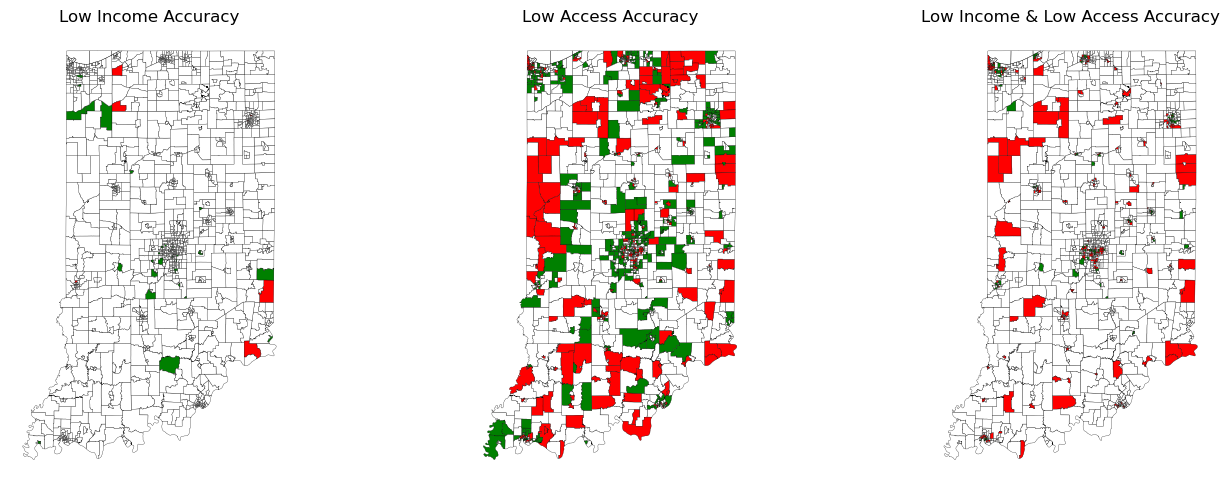

In [145]:
# Defining color mapping for values 0, -1, 1
colors = {0: 'white', -1: 'red', 1: 'green'}
cmap = ListedColormap([colors[-1], colors[0], colors[1]])  # Order: -1, 0, 1

# Creating figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plotting diff_low_income
gdf.plot(column='diff_low_income', cmap=cmap, missing_kwds={'color': 'none'},
         vmin=-1, vmax=1, ax=ax1, edgecolor='black', linewidth=0.2)
ax1.set_title('Low Income Accuracy')
ax1.set_axis_off()

# Plotting diff_low_access
gdf.plot(column='diff_low_access', cmap=cmap, missing_kwds={'color': 'none'},
         vmin=-1, vmax=1, ax=ax2, edgecolor='black', linewidth=0.2)
ax2.set_title('Low Access Accuracy')
ax2.set_axis_off()

# Plotting diff_low_income_low_access
gdf.plot(column='diff_low_income_low_access', cmap=cmap, missing_kwds={'color': 'none'},
         vmin=-1, vmax=1, ax=ax3, edgecolor='black', linewidth=0.2)
ax3.set_title('Low Income & Low Access Accuracy')
ax3.set_axis_off()

# Adjusting layout
plt.tight_layout()